# Forecasting with Prophet and LSTM

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Link - https://www.kaggle.com/c/competitive-data-science-predict-future-sales

In [2]:
!cp drive/My\ Drive/sales_train.csv .

###### Install Basic Requirements

In [1]:
!pip install -r requirements.txt

     |████████████████████████████████| 17.3MB 1.2MB/s 
     |████████████████████████████████| 10.5MB 47.0MB/s 
     |████████████████████████████████| 112kB 43.5MB/s 
     |████████████████████████████████| 13.1MB 10.3MB/s 
     |████████████████████████████████| 8.1MB 16.1MB/s 
     |████████████████████████████████| 7.0MB 47.5MB/s 
     |████████████████████████████████| 92.6MB 45kB/s 
     |████████████████████████████████| 1.5MB 45.2MB/s 
     |████████████████████████████████| 727kB 44.7MB/s 
     |████████████████████████████████| 51kB 6.8MB/s 
     |████████████████████████████████| 92kB 11.6MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 368kB 46.1MB/s 
     |████████████████████████████████| 3.2MB 44.4MB/s 
  Created wheel for fbprophet: filename=fbprophet-0.5-cp36-none-any.whl size=6613089 sha256=3805119ff0d5d5287b33076b216fd96603bbf6cd26e56ae714f1b00db06290e0
  Stored in directory: /root/.cache/pip/wheels/16/61/45/2dce71b

(Need to make changes in import)




In [1]:
import warnings
warnings.filterwarnings("ignore")
from ts_utils import *

###### Basic Data Loading and Formatting

In [ ]:
dtf = pd.read_csv('sales_train.csv')
dtf.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [ ]:

dtf["date"] = pd.to_datetime(dtf['date'], format='%d.%m.%Y')

In [ ]:
dtf.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [ ]:
ts = dtf.groupby("date")["item_cnt_day"].sum().rename("sales")
ts.head()

date
2013-01-01    1951.0
2013-01-02    8198.0
2013-01-03    7422.0
2013-01-04    6617.0
2013-01-05    6346.0
Name: sales, dtype: float64

### 1 - Preprocessing

###### Partitioning into Train and Test

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


--- splitting at index:  881 | 2015-06-01 00:00:00 | test size: 0.15  ---


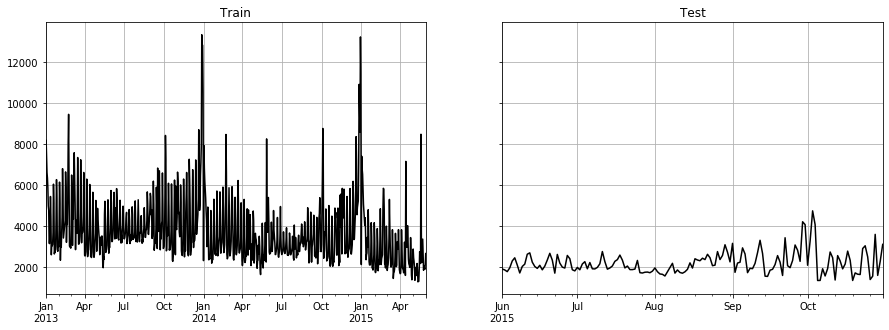

In [ ]:
ts_train, ts_test = split_train_test(ts, test="2015-06-01", plot=True, figsize=(15,5))

### 2 - Prophet

###### Train Model and Evaluate on the Test Split

In [ ]:
dtf_train = ts_train.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf_test = ts_test.reset_index().rename(columns={"date":"ds", "sales":"y"})

dtf_train.tail()

,ds,y
876,2015-05-27,1953.0
877,2015-05-28,1885.0
878,2015-05-29,2146.0
879,2015-05-30,2665.0
880,2015-05-31,2283.0


In [ ]:
model = Prophet()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


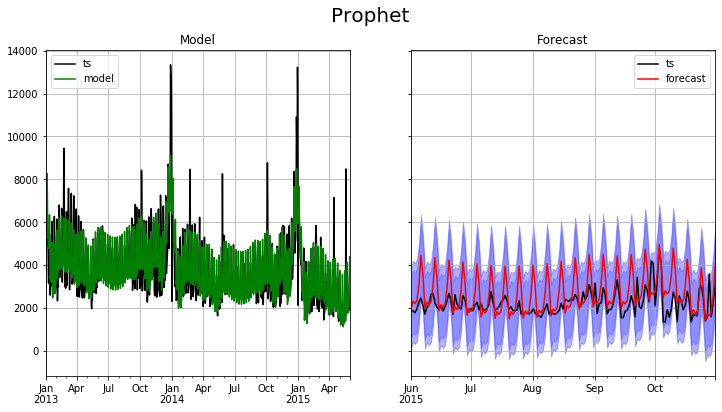

In [ ]:
dtf, model = fit_prophet(dtf_train, dtf_test, model=model, freq="D", figsize=(12,6))

###### Forecasting the same model onto unseen timesteps

In [ ]:
dtf = ts.reset_index().rename(columns={"date":"ds", "sales":"y"})
dtf.tail()

,ds,y
1029,2015-10-27,1551.0
1030,2015-10-28,3593.0
1031,2015-10-29,1589.0
1032,2015-10-30,2274.0
1033,2015-10-31,3104.0


In [ ]:
model = Prophet()

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---


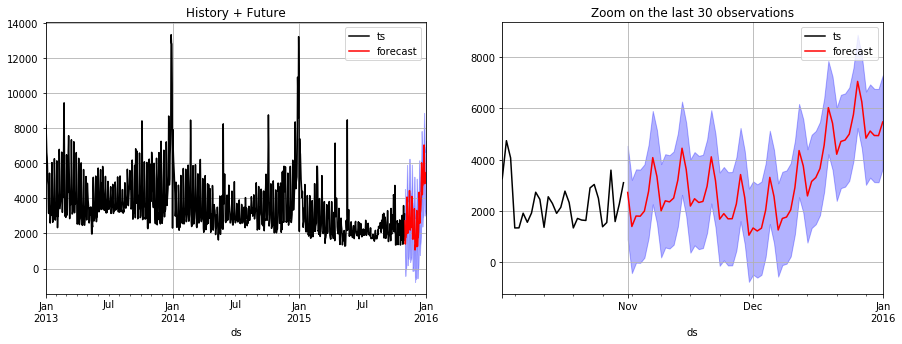

In [ ]:
future = forecast_prophet(dtf, model, end="2016-01-01", freq="D", zoom=30, figsize=(15,5))

### 3 - LSTM

###### Train Model and Evaluate on the Test Split

In [ ]:
s = 365 #Lookback of the LSTM

In [ ]:
model = models.Sequential()
model.add( layers.LSTM(input_shape=(1,s), units=50, activation='relu', return_sequences=False) )
model.add( layers.Dense(1) )
model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Colocations handled automatically by placer.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                83200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 83,251
Trainable params: 83,251
Non-trainable params: 0
_________________________________________________________________


Seasonality: using the last 365 observations to predict the next 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                83200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 83,251
Trainable params: 83,251
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.


Instructions for updating:
Use tf.cast instead.


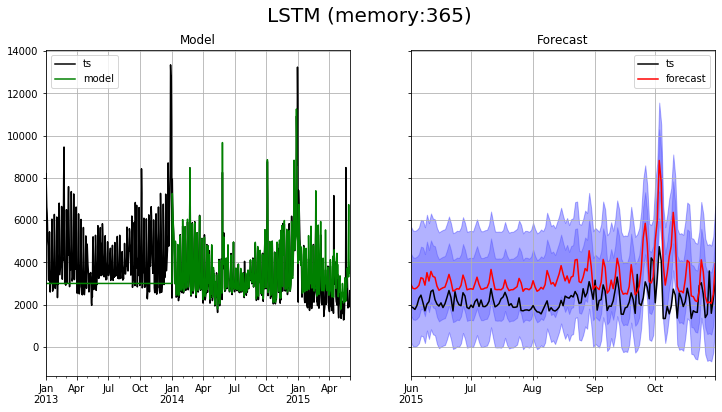

In [ ]:
dtf, model = fit_lstm(ts_train, ts_test, model, s=s, figsize=(12,6))

###### Forecasting the same model onto unseen timesteps

--- generating index date --> start: 2015-11-01 00:00:00 | end: 2016-01-01 00:00:00 | len: 62 ---


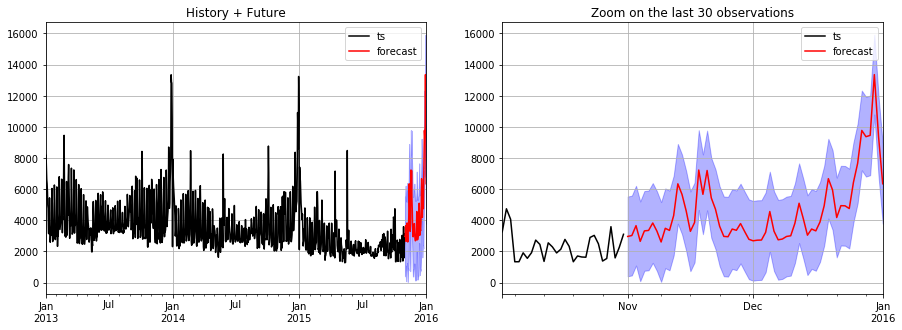

In [ ]:
future = forecast_lstm(ts, model, end="2016-01-01", freq="D", zoom=30, figsize=(15,5))